In [1]:
# The bpnet pipeline saves the model as a .pb file. We have to convert this to an h5 file for compatibility with our pipeline
# import tensorflow as tf

# # Load the SavedModel
# model = tf.keras.models.load_model(model_path)

# # Convert and reset model_path
# model_path = f'{base_dir}/resources/model.h5'
# if hasattr(model, 'save'):
#     model.save(model_path)

In [27]:
# Base directory for all inputs / outputs
base_dir = f'/scratch/users/jgalante/SparseNet/p53'

# Paths to resources
peaks_bed = f"{base_dir}/resources/peaks_inliers.bed"
seqs = f'{base_dir}/resources/genome.fa'
signal_plus = f"{base_dir}/resources/experiment_plus.bw"
signal_minus = f"{base_dir}/resources/experiment_minus.bw"
ctl_plus = f"{base_dir}/resources/control_plus.bw"
ctl_minus = f"{base_dir}/resources/control_minus.bw"
negatives_bed = f"{base_dir}/resources/gc_negatives.bed"
model_path = f'{base_dir}/resources/model.h5'

# Output Directory
out_dir = f'{base_dir}/results'

In [28]:
# Set variables
expansion_factor = 4.0
topk_fraction = 0.05
center_length = 1000
epochs = 3
inner_bs = 16384
lr = 1e-3

# pwm settings
num_samples_per_node = 1000
num_top_nodes = expansion_factor * 64

Loading Loci: 100%|██████████| 10276/10276 [00:11<00:00, 895.44it/s] 



Filtered Peaks: 11
Filtered Negatives: 0


Loading Loci: 100%|██████████| 12845/12845 [00:07<00:00, 1633.55it/s]



[1/9] Training layer: irelu
[irelu] Computing channel max for normalization...
[irelu] Training for 3 epochs...
[irelu] Epoch 1 finished.
[irelu] Epoch 2 finished.
[irelu] Epoch 3 finished.
  ✓ Saved: /scratch/users/jgalante/SparseNet/p53/results/models/irelu.pt

[2/9] Training layer: rrelus.0
[rrelus.0] Computing channel max for normalization...
[rrelus.0] Training for 3 epochs...
[rrelus.0] Epoch 1 finished.
[rrelus.0] Epoch 2 finished.
[rrelus.0] Epoch 3 finished.
  ✓ Saved: /scratch/users/jgalante/SparseNet/p53/results/models/rrelus_0.pt

[3/9] Training layer: rrelus.1
[rrelus.1] Computing channel max for normalization...
[rrelus.1] Training for 3 epochs...
[rrelus.1] Epoch 1 finished.
[rrelus.1] Epoch 2 finished.
[rrelus.1] Epoch 3 finished.
  ✓ Saved: /scratch/users/jgalante/SparseNet/p53/results/models/rrelus_1.pt

[4/9] Training layer: rrelus.2
[rrelus.2] Computing channel max for normalization...
[rrelus.2] Training for 3 epochs...
[rrelus.2] Epoch 1 finished.
[rrelus.2] Epoc

Saved metadata


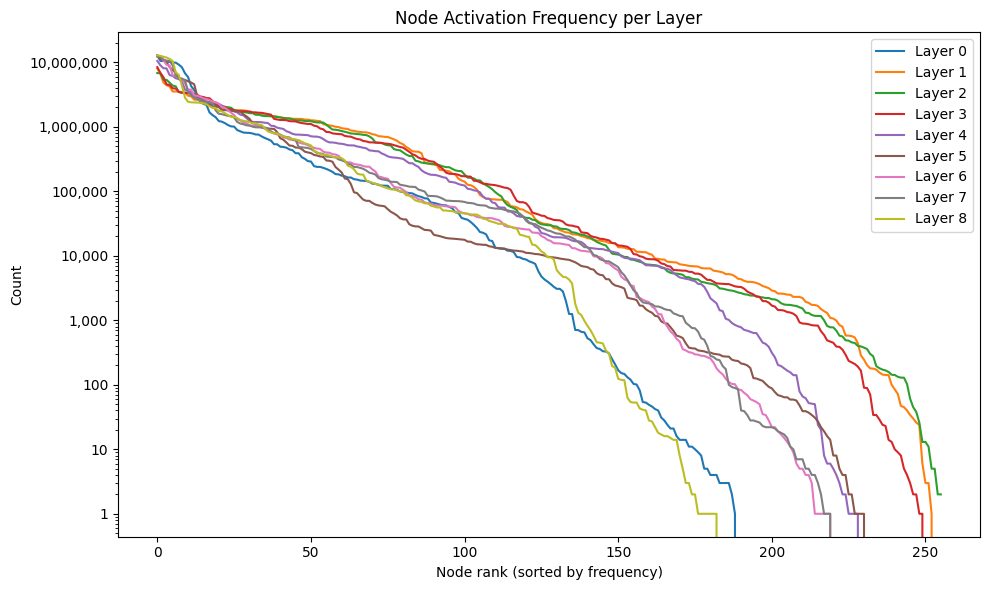

Extracting sequences: 100%|██████████| 201/201 [00:02<00:00, 72.12it/s] 


Plotting grid: 100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


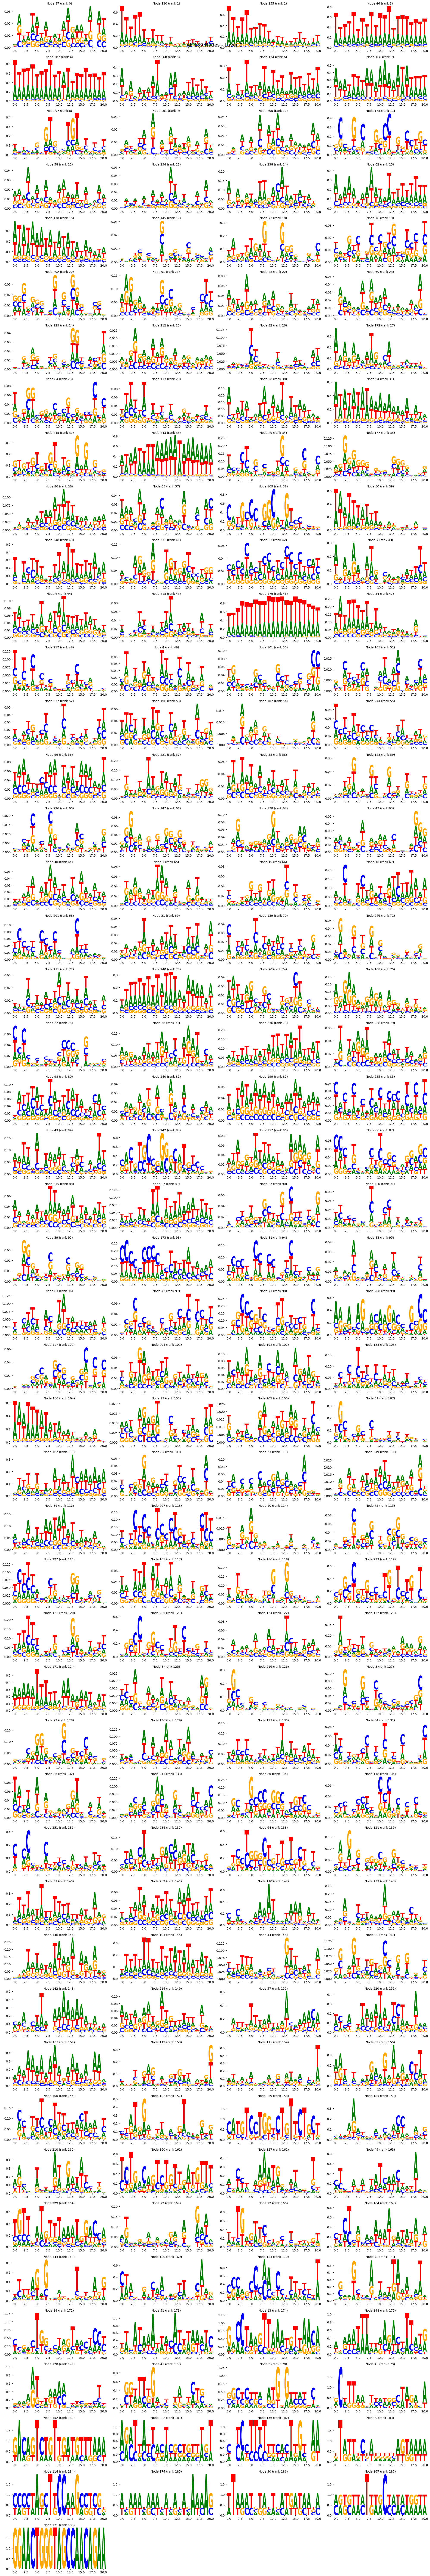

In [29]:
# Prepare training data and other information
import numpy
import os
import torch
from bpnetlite.io import PeakGenerator
from scripts import deterministic_data_loaders as ddl
from scripts import models as mds
from scripts import SAE_trainer as st
from scripts import save_activations as sa
from scripts import plot_activation_frequencies as nf

training_data = PeakGenerator(
    peaks = peaks_bed,
    negatives = negatives_bed,
    sequences = seqs,
    signals = [signal_plus, signal_minus],
    controls = [ctl_plus, ctl_minus],
    chroms = None,
    in_window = 2114,
    out_window = 1000,
    max_jitter = 128,
    negative_ratio = 0.33,
    reverse_complement = True,
    shuffle = True,
    min_counts = None,
    max_counts = None,
    summits = False,
    exclusion_lists = None,
    random_state = 12345,
    pin_memory = True,
    num_workers = 0,
    batch_size = 64,
    verbose = True
)

# Initialize the dataloader to pass all peaks through SAEs and capture activations in order of bed file
sae_testing_data = ddl.DeterministicPeakGenerator(
    peaks=[peaks_bed, negatives_bed],
    sequences=seqs,
    signals=[signal_plus, signal_minus],
    chroms=None,
    in_window=2114,
    out_window=1000,
    pin_memory=True,
    batch_size=64,
    verbose=True
)

# Instantiate the trainer object
trainer = st.SAETrainer(model_path=model_path, device="cuda", center_len=center_length)

# Train an SAE for each layer on all training data with given hyperparameters
trainer.train_all(
    train_loader=training_data,
    sae_cls=mds.SAETopK,
    sae_kwargs={"latent_multiplier": expansion_factor, "k_fraction": topk_fraction},
    save_dir=f'{out_dir}/models',
    logs_dir=f'{out_dir}/models/logs',
    epochs=epochs,
    inner_bs=inner_bs,
    lr=lr,
    log_every=50,
)

# Load the trained SAEs from disk written by trainer.train_all()
sae_models = mds.load_saes_from_dir(save_dir=f'{out_dir}/models', layers=trainer.layers, device=trainer.device)

# Run Top-K collection over deterministic data loader
meta = sa.collect_topk_indices_to_disk_from_trainer(
    trainer=trainer,
    sae_models=sae_models,
    loader=sae_testing_data,
    out_dir=f'{out_dir}/activations',
)

# Plot node activation frequencies
nf.plot_node_activation_frequencies(
	num_layers = len(trainer.layers), 
	latent_dim = int(64*expansion_factor), 
	data_dir = f'{out_dir}/activations'
)

In [ ]:
from scripts import create_PWM_for_nodes as pwm
from scripts import plot_position_nodes as plotpos

pwm_layer = 0
receptive_field = 21 if pwm_layer == 0 else 21 + 2**(pwm_layer + 1)

# Get PWMs for the top N nodes in a given layer over S top activating samples per node
pwm_results = pwm.create_PWM_for_top_N_nodes(
    layer=pwm_layer,
    receptive_field=receptive_field,
    num_top_nodes=num_top_nodes,
    data_dir=f'{out_dir}/activations',
	out_dir = f'{out_dir}/pwms',
    loader=sae_testing_data,
	latent_dim = int(expansion_factor*64), # 64 channels * expansion factor
    num_samples_per_node=num_samples_per_node
)

# Create pwm plots and save
pwm.plot_node_pwms_from_meta(data_dir=f'{out_dir}/pwms')

# Initialize visualizer with saved data
viz = plotpos.SequenceNodeVisualizer(
    activations_dir=f'{out_dir}/activations',
    pwm_dir=f'{out_dir}/pwms',
    loader=sae_testing_data
)

# Plot a sample with its node activations
viz.plot_sample(sample_idx=0, layer_idx=4, top_n_nodes=50)

# Show logos for nodes activated at a specific position
# viz.show_position_logos(position=500, top_k=10, threshold=0.01)
# viz.show_position_logos(position=400, threshold=0.01)

viz.show_position_range_logos(start_pos=490, end_pos=501, threshold=0.0)
viz.show_position_range_logos(start_pos=200, end_pos=211, threshold=0.0)